#**Aprendizaje Automático** - 2023
# Clase 5: Regresión

*Trabajaron en esta notebook: Sofia Del Pozo, Diego Onna, Gaston Bujia*

## Contenido 
* Regresión lineal con Scikit-Learn
* Modelos lineales con regularización
* Tratamiento de variables categóricas y escalas


In [189]:
# Imports necesarios
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## Referencias / Material suplementario

En caso de querer más referencias ver:

- Cap. 3 Linear Methods for Regressiondel del libro [The Elements of Statistical Learning](https://hastie.su.domains/Papers/ESLII.pdf) 

- Cap. 6 Linear Model Selection and Regularization del libro [An Introduction to Statistical Learning](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf)

# Regresion lineal multiple


## Repaso

Para los modelos de regresión lineal supondremos que la relación entre el `target` ($y$) y las `features` ($X$) tiene la siguiente forma:

\begin{equation}
y = \beta_0 + \beta_1x + \beta_2x_2 + \dots + \beta_p x_p + \epsilon
  = \beta_0 + \sum_{j=1}^{p} \beta_j x_j + \epsilon
\end{equation}

Este modelo esta compuesto por sus **parámetros** $\beta_j$, uno para cada **feature** $x_j$ donde $j=1, \ldots, p$ mas el `intercept` ($\beta_0$), y el ruido aleatorio o **residuo** que solemos suponer normal: $\epsilon\sim N(0,\sigma^2)$. Es decir que si consideramos la matriz de entrenamiento `X_train`, esta tendra $p$ columnas y $n$ filas donde $n$ es la cantidad de datos de entrenamiento.

Para entrenar el modelo tenemos que calcular los valores de los parametros $\beta$ (todos), lo que se suele hacer es minimizar la función de pérdida cuadrática $\cal L(\beta_0, \ldots, \beta_p)$:

\begin{equation}
\cal L(\beta) =  \frac{1}{n}\sum_{i=1}^{n} \big (y_i - (\beta_0 + \sum_{j=1}^{p} \beta_j x_{ij})) ^2
\end{equation}

Podemos simplificar la expresión escribiendo los errores o residuos (muestrales) $e_i = y_i-y_i^*$ donde la prediccion del modelo será $y_i^* = \beta_0 + \sum_{j=1}^p \beta_{j} x_{ij}$:

\begin{equation}
\cal L(\beta) = \frac{1}{n} \sum_{i=1}^{n} e^2
\end{equation}


Luego fijado $X$ los mejores $\hat\beta$'s los hallamos como los que minimizan el error:

\begin{equation}
\hat\beta =  \arg\min_{\beta} \cal L(\beta)
\end{equation}

---
**Nota importante:**
Los modelos lineales tienen excelentes propiedades estadísticas (es un estimador [insesgado de minima varianza uniforme](https://es.wikipedia.org/wiki/Estimador_insesgado_de_varianza_m%C3%ADnima)) pero para poder cumplir esas propiedades tienen unos supuestos fuertes para garantizarlo conocidas como los [supuestos de Gauss-Markov](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) que se pueden resumir en:

-    *Linealidad*: La relación entre la variable dependiente ($Y$) y la variable independiente ($X$) debe ser lineal
-    *Normalidad de los residuos*: Los residuos deben tener una distribución normal.
-    *Homogeneidad de la varianza de los residuos*: Los residuos deben tener una varianza constante (homocedasticidad).
-    *Independencia de los residuos*: Los residuos deben ser independientes los unos de los otros, no deben estar correlacionados entre sí.

Todo este tema lo profundizarán en la materia de Modelos Lineales (Enfoque estadístico del aprendizaje y descubrimiento).

---


## Ejemplo: de nuevo el dataset de diabetes

Volveremos a utilizar el conjunto de datos de la diabetes. El dataset "diabetes" contiene un total de 442 observaciones y 10 variables (características) numéricas. Las variables del dataset "diabetes" son las siguientes:

    Edad: Edad del paciente en años.
    Sexo: Sexo del paciente (0 = Femenino, 1 = Masculino).
    Índice de masa corporal (IMC): Medida del peso en relación con la altura del paciente.
    Presión arterial media (MAP): Medida de la presión arterial promedio del paciente.
    Tasa de s1 de serología del suero: Un indicador del nivel de s1 de serología del suero del paciente.
    Tasa de s2 de serología del suero: Un indicador del nivel de s2 de serología del suero del paciente.
    Tasa de s3 de serología del suero: Un indicador del nivel de s3 de serología del suero del paciente.
    Tasa de s4 de serología del suero: Un indicador del nivel de s4 de serología del suero del paciente.
    Tasa de s5 de serología del suero: Un indicador del nivel de s5 de serología del suero del paciente.
    Tasa de s6 de serología del suero: Un indicador del nivel de s6 de serología del suero del paciente.

El target o variable de salida en el dataset es la *progresión de la diabetes* en un año. Esta variable representa la medida de la progresión de la enfermedad en un año para cada paciente en el estudio. Es un valor numérico continuo que indica la magnitud de la progresión de la diabetes en un año, y se utiliza como la variable objetivo en los modelos de regresión construidos con este dataset.

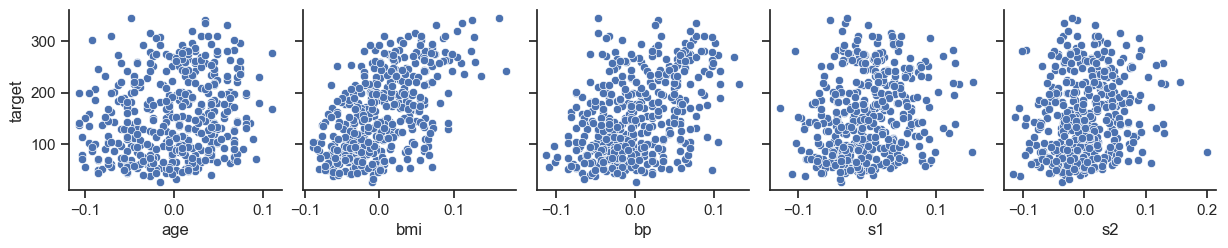

In [190]:
diabetes_data = load_diabetes()
diabetes = pd.DataFrame(diabetes_data['data'], columns=diabetes_data['feature_names'])
diabetes['target'] = diabetes_data['target']

# Visualización de algunas variables utilizando Seaborn
sns.set(style='ticks')
sns.pairplot(diabetes, x_vars=['age', 'bmi', 'bp', 's1', 's2'], y_vars='target', kind='scatter')
plt.show()

---
**Mini ejercicio 1**

Observe la distribución de las features, ¿nota algo en particular? *Mini ejercicio*: Calcule medias, desvios de cada columna y calcule la matriz de correlaciones.

age      -3.639623e-16
sex       1.309912e-16
bmi      -8.013951e-16
bp        1.289818e-16
s1       -9.042540e-17
s2        1.301121e-16
s3       -4.563971e-16
s4        3.863174e-16
s5       -3.848103e-16
s6       -3.398488e-16
target    1.521335e+02
dtype: float64

age        0.047619
sex        0.047619
bmi        0.047619
bp         0.047619
s1         0.047619
s2         0.047619
s3         0.047619
s4         0.047619
s5         0.047619
s6         0.047619
target    77.093005
dtype: float64

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

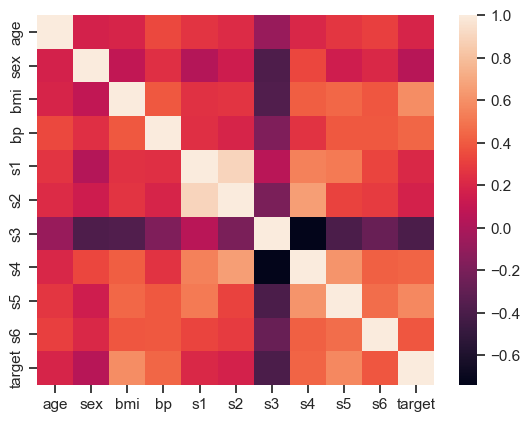

In [191]:
display(diabetes.mean())
display(diabetes.std())
display(diabetes.target.describe())
sns.heatmap(diabetes.corr());

---

### Entrenamos un modelo lineal: split
Creemos una separación de datos, para eso usaremos un split de `train`, `val` y `test`. El test no lo utilizaremos hasta tener el mejor de todos los modelos: 

![image.png](https://cdn.shortpixel.ai/spai/q_lossy+w_730+to_webp+ret_img/https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png)

In [192]:
# Separación del dataset en train, dev y test
X = diabetes.drop('target', axis=1)
y = diabetes['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

¿Cómo quedaron las relacciones finales de train, validation y test?

In [193]:
print(diabetes.shape)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

(442, 11)
Tamaño del conjunto de entrenamiento: (247, 10)
Tamaño del conjunto de validación: (106, 10)
Tamaño del conjunto de prueba: (89, 10)


In [194]:
# Creación y entrenamiento del modelo de regresión lineal
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred_clasica = reg_linear.predict(X_val)

# Cálculo del error cuadrático medio en el conjunto de validación
mse_clasica = mean_squared_error(y_val, y_val_pred_clasica)

print("Error cuadrático medio (Clásica):", mse_clasica)

Error cuadrático medio (Clásica): 2869.329583280275


### Interpretación de los $\beta$
Si tenemos en general a los **features normalizados** con media 0 y varianza 1, y son independientes entre si (o en su defecto poco correlacionados), los $\beta$ **se pueden interpretar de alguna manera como un proxy de importancia**. Esto quiere decir que el valor del coeficiente me dice cuanto aporta la variación en el feature correspondiente al cambio en el target. Por ejemplo, si el coeficiente $\beta_j$ es negativo, aumentar el feature $x_j$ correspondiente impacta disminuyendo el valor del target.

---
**Mini ejercicio 2**

[   43.89663881  -238.88788744   480.97913846   303.46857722
 -1042.2979151    600.61836729   149.54139783   236.10027021
   848.29500766    73.85881009]


<AxesSubplot:>

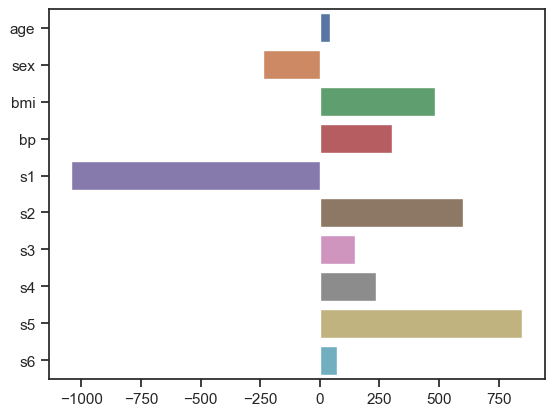

In [195]:
# IMPRIMIR LOS BETAS EN UN BAR PLOT DICIENDO QUE FEATURE ES CADA UNA
# COMPLETAR
print(reg_linear.coef_)

sns.barplot(x= reg_linear.coef_, y =diabetes_data['feature_names'] )

# Regresión lineal con regularización

La regularización de un modelo lineal se refiere a la técnica utilizada para evitar el sobreajuste (overfitting) del modelo. Es decir, se evita que el modelo ajuste demasiado a los datos de entrenamiento para mejorar el desempeño en la predicción de nuevos datos.

Una de las formas estandar de regularizar un modelo es mediante la penalizacion de los valores de los parametros de nuestro modelo. En regresion lineal existen dos maneras muy usuales de hacer: penalizacion Ridge o Lasso. La principal diferencia entre estas técnicas es cómo tratan los coeficientes del modelo.
Ridge tiende a reducir todos los coeficientes, mientras que Lasso tiene el efecto de reducir algunos coeficientes a cero, eliminando así algunos predictores del modelo.

Estos metodos introducen un nuevo hiperparametro (en general representados con la letra $\lambda$ o en el caso de regresion lineal se suele utilizar $\alpha$) que modula que tanto queremos penalizar el modelo. Valores altos de este hiperparametros penalizaran fuertemente el modelo tendiendo a reducir fuertemente la varianza.

## Regularización Ridge ($L^2$)

La penalización utilizada por el modelo Ridge queda de la siguiente manera:

\begin{equation}
\cal L(\beta, \alpha) = \sum_{i=1}^{n} (y_i - (\beta_0 + \sum_{j=1}^{p} \beta_j x_{ij})) ^2 + \alpha \sum_{j=1}^{p} {\beta_j}^2
\end{equation}

donde:

- $y$ es la variable de respuesta
- $\beta_0$ es el intercept
- $x_j$ es la $j$-ésima variable predictora/feature
- $\beta_j$ es el coeficiente correspondiente a la $j$-ésima variable predictora
- $\alpha$ es el **hiperparámetro** de regularización que controla la fuerza de la penalización de la magnitud de los coeficientes.

*Nota*: La última parte de la ecuación, $\sum_{j=1}^{p} \beta_j^2$, es la función de penalización $L^2$ regulada por $\alpha>0$ que penaliza más fuertemente a los coeficientes más grandes.

In [196]:
# Creación y entrenamiento del modelo de regresión con Ridge
reg_ridge = Ridge(alpha=0.1) # Seleccionamos un valor de alpha (hiperparámetro) de 0.1
reg_ridge.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred_ridge = reg_ridge.predict(X_val)

# Cálculo del error cuadrático medio en el conjunto de validación
mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)

print("Error cuadrático medio (Ridge):", mse_ridge)

Error cuadrático medio (Ridge): 2909.709525354801


## Regularización Lasso ($L^1$)

La penalización utilizada por el modelo Lasso queda de la siguiente manera:

\begin{equation}
\cal L(\beta, \alpha) = \sum_{i=1}^{n} (y_i - (\beta_0 + \sum_{j=1}^{p} \beta_j x_{ij})) ^2 + \alpha \sum_{j=1}^{p} |\beta_j|
\end{equation}

*Nota*: La última parte de la ecuación, $\sum_{j=1}^{p} |\beta_j|$, es la función de penalización $L^1$ regulada por $\alpha>0$ que obliga a algunos coeficientes a ser exactamente cero, lo que conduce a una selección de features integrada.

In [197]:
# Creación y entrenamiento del modelo de regresión con Lasso
reg_lasso = Lasso(alpha=0.1) # Seleccionamos un valor de alpha (hiperparámetro) de 0.1
reg_lasso.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred_lasso = reg_lasso.predict(X_val)

# Cálculo del error cuadrático medio en el conjunto de validación
mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)

print("Error cuadrático medio (Lasso):", mse_lasso)

Error cuadrático medio (Lasso): 2882.245776343751


In [198]:
# Comparemos los resultados obtenidos hasta aca en val
print("Error cuadrático medio (Lasso):", mse_lasso)
print("Error cuadrático medio (Ridge):", mse_ridge)
print("Error cuadrático medio (Clásica):", mse_clasica)

Error cuadrático medio (Lasso): 2882.245776343751
Error cuadrático medio (Ridge): 2909.709525354801
Error cuadrático medio (Clásica): 2869.329583280275


## Efecto del $\alpha$ 

Estas técnicas a veces se denominan **shrinkage** (contracción o encojimiento), porque hacen que los parámetros del modelo se reduzcan a cero. Veamos la evolución de los valores de los parámetros a medida que pasamos de valores pequeños a grandes del término de penalización para cada tipo de regularización vista.

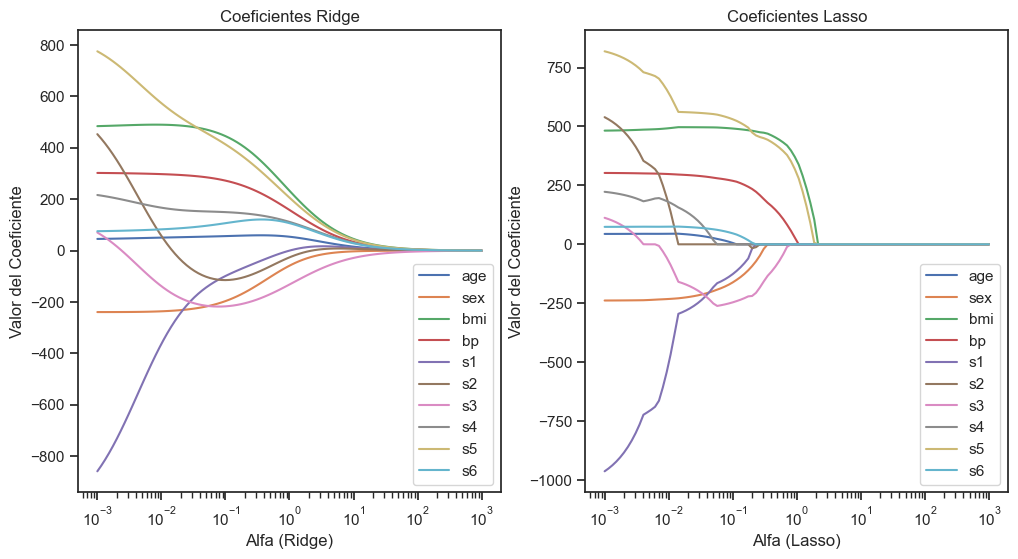

In [199]:
# Creación de la grilla de valores de alfa
alphas = np.logspace(-3, 3, 100)

# Creación de subplots para los plots de Ridge y Lasso
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Cálculo y graficar los coeficientes (betas) para Ridge
for i, feature_name in enumerate(X_train.columns):
    coef_ridge = []
    for alpha in alphas:
        reg_ridge = Ridge(alpha=alpha)
        reg_ridge.fit(X_train, y_train)
        coef_ridge.append(reg_ridge.coef_[i])
    axes[0].plot(alphas, coef_ridge, label=feature_name)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alfa (Ridge)')
axes[0].set_ylabel('Valor del Coeficiente')
axes[0].set_title('Coeficientes Ridge')
axes[0].legend()

# Cálculo y graficar los coeficientes (betas) para Lasso
for i, feature_name in enumerate(X_train.columns):
    coef_lasso = []
    for alpha in alphas:
        reg_lasso = Lasso(alpha=alpha)
        reg_lasso.fit(X_train, y_train)
        coef_lasso.append(reg_lasso.coef_[i])
    axes[1].plot(alphas, coef_lasso, label=feature_name)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alfa (Lasso)')
axes[1].set_ylabel('Valor del Coeficiente')
axes[1].set_title('Coeficientes Lasso')
axes[1].legend()

plt.show()

## Eligiendo $\alpha$ con Cross Validation

Scikit-learn nos permite elegir el valor de alfa para Ridge y Lasso utilizando cross-validation con los metodos: [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) y [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Estos metodos lo que hacen es dado un conjunto de alfas y una cantidad de folds (ver documentacion parametro `cv`) elegir el mejor de los alfas y con dicho alfa ajustar el modelo de nuevo a todos los datos. Veamoslo con un ejemplo:



In [200]:
alphas = np.logspace(-10, 3, 100)

reg_ridgeCV =RidgeCV(alphas=alphas, cv=None, store_cv_values=True)
reg_lassoCV = LassoCV(alphas=alphas, cv=5)

reg_ridgeCV.fit(X_train, y_train);
reg_lassoCV.fit(X_train, y_train);

Mejor alfa encontrado: 0.06280291441834272
Error cuadrático medio (RidgeCV): 2892.3302671978076
parámetros [  55.22749716 -211.67168366  464.58790816  282.06012541 -126.57268986
 -109.06246178 -216.83123541  151.82514674  444.23815908   99.81415049]


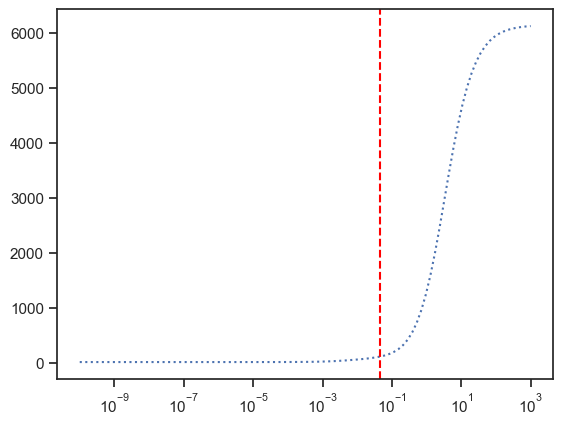

In [201]:
# Predicciones en el conjunto de validación para Lasso
y_val_pred_ridgeCV = reg_ridgeCV.predict(X_val)

# Cálculo del error cuadrático medio en el conjunto de validación
mse_ridgeCV = mean_squared_error(y_val, y_val_pred_ridgeCV)

print("Mejor alfa encontrado:", reg_ridgeCV.alpha_)
print("Error cuadrático medio (RidgeCV):", mse_ridgeCV)
print("parámetros", reg_ridgeCV.coef_)

plt.semilogx(reg_ridgeCV.alphas, reg_ridgeCV.cv_values_[1], linestyle=":");
plt.axvline(reg_lassoCV.alpha_, linestyle="--", color= "red");

best_alpha_ridgeCV = reg_ridgeCV.alpha_

In [202]:
# Predicciones en el conjunto de validación para Lasso
y_val_pred_lassoCV = reg_lassoCV.predict(X_val)

# Cálculo del error cuadrático medio en el conjunto de validación
mse_lassoCV = mean_squared_error(y_val, y_val_pred_lassoCV)

print("Mejor alfa encontrado:", reg_lassoCV.alpha_)
print("Error cuadrático medio (LassoCV):", mse_lassoCV)
print("parámetros", reg_lassoCV.coef_)

best_alpha_lassoCV = reg_lassoCV.alpha_

Mejor alfa encontrado: 0.04641588833612791
Error cuadrático medio (LassoCV): 2879.077419848427
parámetros [  28.12930978 -201.25804898  496.21797337  283.98757961 -192.43710825
   -0.         -242.38840792   30.60077167  553.54388345   64.86644431]


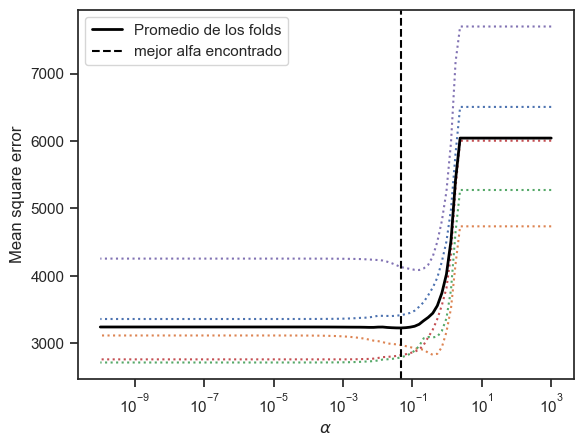

In [203]:
# Podemos visualizar los errores que tuvo en cada fold accediendo al atributo mse_path_ 
# OJO: si quieren graficar el de Ridge en vez de acceder a los alfas mediante MODELO.alphas_, se llaman MODELO.alpha
plt.semilogx(reg_lassoCV.alphas_, reg_lassoCV.mse_path_, linestyle=":")
plt.plot(
    reg_lassoCV.alphas_,
    reg_lassoCV.mse_path_.mean(axis=-1),
    color="black",
    label="Promedio de los folds",
    linewidth=2,
)

plt.axvline(reg_lassoCV.alpha_, linestyle="--", color="black", label="mejor alfa encontrado")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.show()

---
# Ejercicio

1 - Para `Ridge` y para `Lasso`, grafique el error de entrenamiento y validación en función de los alphas utilizados en la sección de "Efecto del alfa". ¿Qué observa? Relacionelo con el dilema sesgo-varianza y el rol de la regularización en ese trade-off, ¿que sucede con alfas muy altos y que sucede con alfas muy bajos?


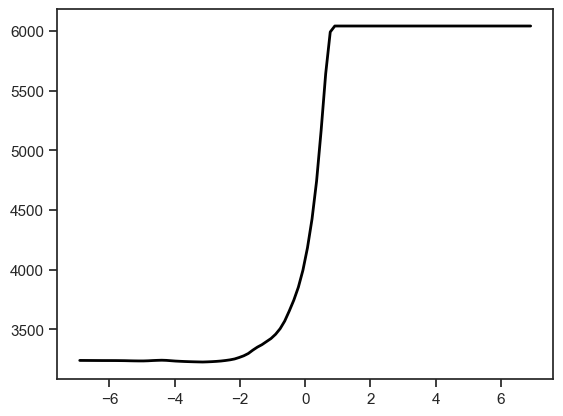

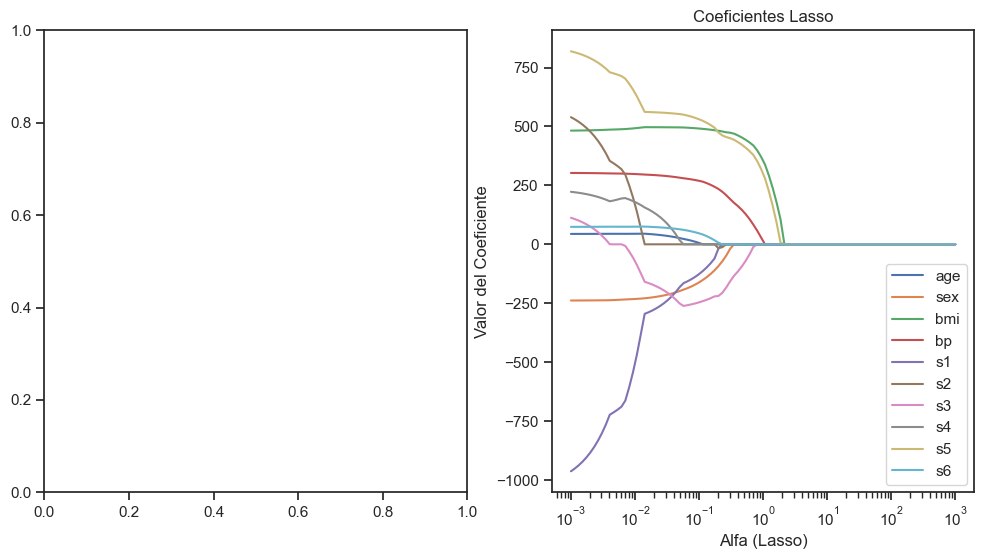

In [204]:
# Creación de la grilla de valores de alfa
alphas = np.logspace(-3, 3, 100)

reg_lassoCV = LassoCV(alphas=alphas, cv=5)
reg_lassoCV.fit(X_train, y_train)

y_val_pred_lassoCV = reg_lassoCV.predict(X_val)
plt.plot(
    np.log(reg_lassoCV.alphas_),
    reg_lassoCV.mse_path_.mean(axis=-1),
    color="black",
    label="Promedio de los folds",
    linewidth=2,
)
# Cálculo del error cuadrático medio en el conjunto de validación
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, feature_name in enumerate(X_train.columns):
    coef_lasso = []
    for alpha in alphas:
        reg_lasso = Lasso(alpha=alpha)
        reg_lasso.fit(X_train, y_train)
        coef_lasso.append(reg_lasso.coef_[i])
    axes[1].plot(alphas, coef_lasso, label=feature_name)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alfa (Lasso)')
axes[1].set_ylabel('Valor del Coeficiente')
axes[1].set_title('Coeficientes Lasso')
axes[1].legend()

plt.show()

## ElasticNet

[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) es un modelo que no veremos en detalle pero lo que hace es combinar los dos tipos de regularización, utilizando un hiperparámetro nuevo $\rho$ que regula que tanto peso le da a cada una de las regularizaciones. 

\begin{equation} 
\cal L(\beta) = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}x_{ij}\beta_j)^2 + \alpha(\rho\sum_{j=1}^{p}|\beta_j| + \frac{1-\rho}{2}\sum_{j=1}^{p}\beta_j^2)
\end{equation}


2 - Cree una celda de código para ajustar un modelo de Elastic Net utilizando $\alpha=0.1$ y $\rho=0.5$ en el conjunto de datos de diabetes siguiendo la partición dada en la notebook, si es necesario recurra a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

In [205]:
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=132)
elastic.fit(X_train, y_train)

y_pred_elastic = elastic.predict(X_val)
mse_elastic = mean_squared_error(y_val, y_pred_elastic)
print(mse_elastic)

5609.010185500792



3 - Elija ambos hiperparametros de ElasticNet usando Validación Cruzada en el conjunto `X_dev`. Defina una grilla para eso que tenga al menos 10 puntos espaciados logaritmicamente para cada hiperparámetro. Utilice la función provista por sklearn: [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV)



C:\Users\igalk\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10289.62729459966, tolerance: 115.92522741116751
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\igalk\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141668.63569260415, tolerance: 115.92522741116751
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\igalk\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230995.4589353363, tolerance: 115.92522741116751
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\igalk\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

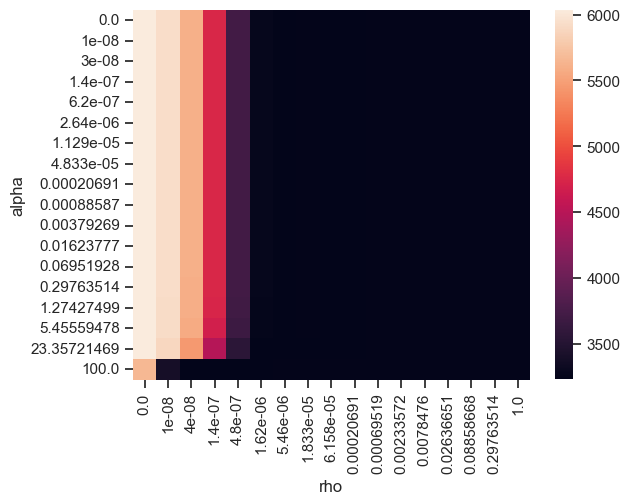

In [208]:
rhos = np.logspace(-10,0,20)
alphas = np.logspace(-10,2,20)
elasticCV=ElasticNetCV(l1_ratio= rhos, alphas=alphas, max_iter=10000)
elasticCV.fit(X_train, y_train)

y_pred_elasticCV = elasticCV.predict(X_val)
best_alpha_elasticCV, best_rho_elasticCV = elasticCV.alpha_, elasticCV.l1_ratio_

elasticCV_rtdo=pd.DataFrame(columns=["alpha", "rho", "CV_mean"])
lista=[]
for alpha in range(len(alphas)):
    for rho in range(len(rhos)):
        dict={"alpha": round(alphas[alpha],8),
              "rho": round(rhos[rho],8),
              "CV_mean": elasticCV.mse_path_[alpha][rho].mean()
                }
        lista.append(dict)

elasticCV_rtdo = pd.DataFrame.from_dict(lista)
piv = pd.pivot_table(elasticCV_rtdo, values="CV_mean",index=["alpha"], columns=["rho"], fill_value=0)
sns.heatmap(piv);




4 - Compare los 4 mejores modelos (Ridge, Lasso, ElasticNet y sin regularizar) en el conjunto de `test`. ¿Cuál fue el mejor modelo? Para el mejor modelo, ¿cuál fue la variable que tiene un mayor efecto positivo en el aumento de la glucosa?

In [94]:
best_alpha_lassoCV

0.04328761281083059

In [109]:

#best_models = pd.DataFrame(columns=["model", "MSE"])
lista=[]

#RidgeCV
best_reg_ridgeCV = LassoCV(alphas=[best_alpha_ridgeCV], cv=5)
best_reg_ridgeCV.fit(X_temp, y_temp)
y_pred_best_ridgeCV = best_reg_ridgeCV.predict(X_test)
mse_best_ridgeCV = mean_squared_error(y_test, y_pred_best_ridgeCV)

lista.append({"model":"best_ridgeCV",
              "MSE": mse_best_ridgeCV})

#lassoCV
best_reg_lassoCV = LassoCV(alphas=[best_alpha_lassoCV], cv=5)
best_reg_lassoCV.fit(X_temp, y_temp)
y_pred_best_lassoCV = best_reg_lassoCV.predict(X_test)
mse_best_lassoCV = mean_squared_error(y_test, y_pred_best_lassoCV)

lista.append({"model":"best_lassoCV",
              "MSE": mse_best_lassoCV})

#elasticCV
best_alpha_rho_elasticCV=ElasticNetCV(l1_ratio=[best_rho_elasticCV] , alphas=[best_alpha_elasticCV], max_iter=10000)
best_alpha_rho_elasticCV.fit(X_temp, y_temp)

y_pred_best_alpha_rho_elasticCV = best_alpha_rho_elasticCV.predict(X_test)

mse_best_elasticCV = mean_squared_error(y_test, y_pred_best_alpha_rho_elasticCV)

lista.append({"model":"best_elasticCV",
              "MSE": mse_best_elasticCV})


reg_linear = LinearRegression()
reg_linear.fit(X_temp, y_temp)
y_pred_reg_linear = reg_linear.predict(X_test)
mse_reg_linear = mean_squared_error(y_test, y_pred_reg_linear)


lista.append({"model":"best_reg_linear",
              "MSE": mse_reg_linear})

best_models = pd.DataFrame.from_dict(lista).sort_values("MSE")
display(best_models)

best_reg_ridgeCV.coef_

#el coeficiente mas alto es 554 de la variables BMI, este importante peso podía anticiparse en la alta correlación con la variable target que se observaba en el heatmap inicial

,model,MSE
0,best_ridgeCV,2807.874366
1,best_lassoCV,2829.363330
2,best_elasticCV,2855.657334
3,best_reg_linear,2900.173288


{'eps': 0.001,
 'n_alphas': 100,
 'alphas': [0.06280291441834272],
 'fit_intercept': True,
 'normalize': False,
 'precompute': 'auto',
 'max_iter': 1000,
 'tol': 0.0001,
 'copy_X': True,
 'cv': 5,
 'verbose': False,
 'n_jobs': None,
 'positive': False,
 'random_state': None,
 'selection': 'cyclic',
 'n_features_in_': 10,
 'mse_path_': array([2866.52674517, 3372.3178964 , 2736.33969246, 3275.86296988,
        3383.76834954]),
 'alpha_': 0.06280291441834272,
 'alphas_': array([0.06280291]),
 'coef_': array([   4.66696419, -180.74191736,  554.78812115,  317.5883383 ,
        -128.61609557,   -0.        , -224.20440375,   21.02182553,
         468.2028142 ,   41.03482357]),
 'intercept_': 151.47753905275465,
 'dual_gap_': 57.27433293533977,
 'n_iter_': 45}

---
# EXTRA - Tratamiento de variables categóricas y escalas

El tratamiento de variables categóricas es una parte importante en el preprocesamiento de datos en el análisis de datos. Las variables categóricas son aquellas que toman valores de una lista predefinida de categorías o etiquetas.

Existen varios métodos para el tratamiento de variables categóricas, siendo los más comunes:

* **Codificación One-Hot**: esta técnica consiste en transformar las variables categóricas en variables binarias (0 o 1) para cada categoría. Cada categoría se convierte en una nueva variable, en la que se utiliza un valor de 1 si la observación corresponde a esa categoría y un valor de 0 si no. Esta técnica es útil cuando no existe un orden inherente en las categorías.

* **Codificación ordinal**: cuando las categorías tienen un orden natural, como en el caso de niveles educativos (primaria, secundaria, universidad), se puede asignar un valor numérico a cada categoría y tratar la variable categórica como si fuera una variable numérica.

* **Codificación de frecuencia**: se puede utilizar la frecuencia de cada categoría como un valor numérico y tratar la variable categórica como si fuera una variable numérica.

* **Codificación de etiquetas**: en este método, cada categoría se asigna a un valor numérico único y arbitrario, por ejemplo, asignar 1 a la categoría "Hombre" y 2 a la categoría "Mujer". Este enfoque se utiliza cuando no existe un orden inherente en las categorías, pero también se pueden utilizar valores numéricos que reflejen un orden lógico en las categorías.

Es importante tener en cuenta que la elección del método de tratamiento de variables categóricas depende del tipo de análisis que se está realizando y de la relación entre las categorías de la variable. Además, algunos modelos de aprendizaje automático como los árboles de decisión y los random forest pueden manejar variables categóricas sin la necesidad de convertirlas en variables numéricas.

La librería SkLearn tiene varias funciones que sirven para este proposito:

* [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* [sklearn.preprocessing.OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
* [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)



Ejemplo obtenido de: 
[Ordinal and One-Hot Encodings for Categorical Data](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/)


Trabajaremos con un dataset de "Cáncer de Mama", que ha sido ampliamente estudiado en el campo del aprendizaje automático desde la década de 1980.

El conjunto de datos clasifica los datos de pacientes con cáncer de mama como recurrencia o no recurrencia de cáncer. Los datos incluye 201 instancias de una clase y 85 instancias de otra clase. Las instancias están descritas por 9 atributos, algunos de los cuales son lineales y otros nominales. Se trata de un problema de clasificación binaria.

In [113]:
# evaluate logistic regression on the breast cancer dataset with an ordinal encoding
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [133]:
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv", header=None)
# retrieve the array of data
data = dataset.values
# separate into input and output columns
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
data

array([["'40-49'", "'premeno'", "'15-19'", ..., "'left_up'", "'no'",
        "'recurrence-events'"],
       ["'50-59'", "'ge40'", "'15-19'", ..., "'central'", "'no'",
        "'no-recurrence-events'"],
       ["'50-59'", "'ge40'", "'35-39'", ..., "'left_low'", "'no'",
        "'recurrence-events'"],
       ...,
       ["'30-39'", "'premeno'", "'30-34'", ..., "'right_up'", "'no'",
        "'no-recurrence-events'"],
       ["'50-59'", "'premeno'", "'15-19'", ..., "'left_low'", "'no'",
        "'no-recurrence-events'"],
       ["'50-59'", "'ge40'", "'40-44'", ..., "'right_up'", "'no'",
        "'no-recurrence-events'"]], dtype=object)

In [115]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

##Codificación One-Hot

In [116]:
# one-hot encode input variables
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train)
X_train_onehot = onehot_encoder.transform(X_train)
X_test_onehot = onehot_encoder.transform(X_test)
# define the model
model = LogisticRegression()
# fit on the training set
model.fit(X_train_onehot, y_train)
# predict on test set
yhat = model.predict(X_test_onehot)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))


Accuracy: 70.53


OneHotEnconder tiene la opcción de *drop{‘first’, ‘if_binary’} or an array-like of shape (n_features,), default=None*

Especificando una metodología para eliminar una de las categorías por característica. Esto es útil en situaciones en las que las características perfectamente colineales causan problemas, como cuando se introducen los datos resultantes en un modelo de regresión lineal no regularizado.

Sin embargo, la eliminación de una categoría rompe la simetría de la representación original y, por lo tanto, puede inducir un sesgo en los modelos posteriores, por ejemplo, en los modelos de clasificación o regresión lineal penalizados.



##Codificación Ordinal

In [117]:
# ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train_ordinal = ordinal_encoder.transform(X_train)
X_test_ordinal = ordinal_encoder.transform(X_test)
# define the model
model = LogisticRegression()
# fit on the training set
model.fit(X_train_ordinal, y_train)
# predict on test set
yhat = model.predict(X_test_ordinal)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.79


¿Por qué razón pueden dar diferente precisión ambos modelos? ¿Uno de los dos encoders da más información?

## Ejercicio
Realizar una regresión lineal para predecir la propina acorde al gasto en la comida. En el conjunto de datos hay varias variables categoricas que son necesarias tratar para hacer un modelo de regresión lineal.



[Info del Dataset](https://rdrr.io/cran/reshape2/man/tips.html)





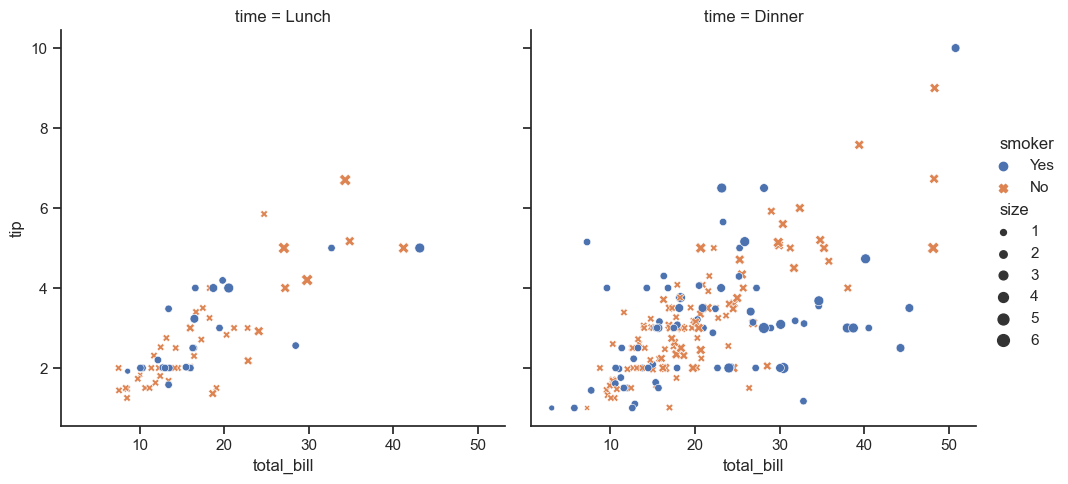

In [211]:
import seaborn as sns

tips = sns.load_dataset("tips")

sns.relplot(data=tips, x="total_bill", y="tip", col="time", hue="smoker", style="smoker", size="size")


In [212]:
X = tips.drop(columns=["tip"])
y = tips["tip"]

X.time.drop_duplicates()

0     Dinner
77     Lunch
Name: time, dtype: category
Categories (2, object): ['Lunch', 'Dinner']

1.1204397318797668
R2 is 0.48209631426306854


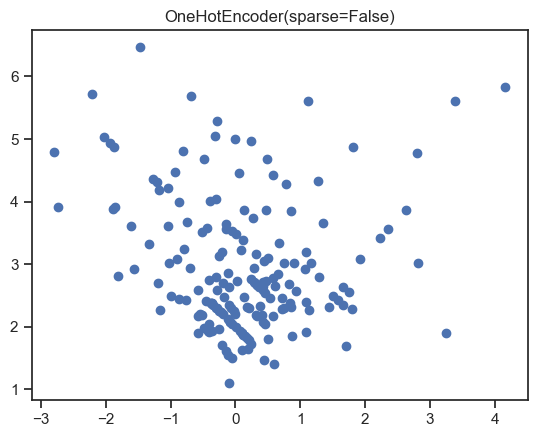

1.1190332030731691
R2 is 0.47420428643242774


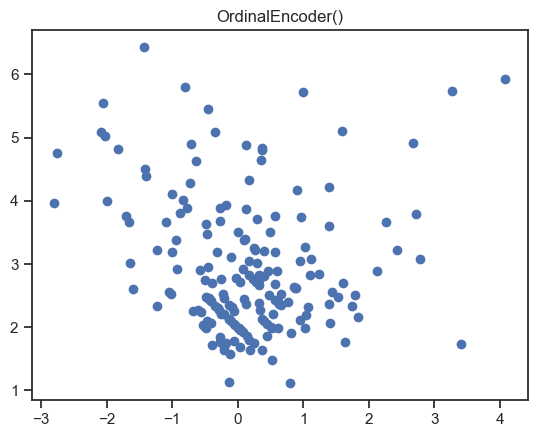

In [215]:
for encoders in [OneHotEncoder(sparse=False), OrdinalEncoder()]:
    encoder = encoders
    encoder.fit(X[["sex","smoker", "day", "time"]])
    X_encoded = encoder.transform(X[["sex","smoker", "day", "time"]])
    try:
        X_encoded = pd.DataFrame(X_encoded, columns=["Sex_F", "Sex_M","Smoker_N", "Smoker_Y",
                                                 "day_Sun", "day_Sat", "day_Thur", "day_fri",
                                                 "time_dinner", "time_lunch"])

    except:

        X_encoded = pd.DataFrame(X_encoded, columns=["sex","smoker", "day", "time"])

    finally:

        X_encoded = pd.concat([X[["total_bill", "size"]], X_encoded], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,train_size=.25, random_state=123)

        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_pred_LR = LR.predict(X_test)
        mse_LR = mean_squared_error(y_test, y_pred_LR)
        print(mse_LR)
        print(f"R2 is {LR.score(X_train, y_train)}")
        #análisis de residuos
        plt.scatter(y_test - y_pred_LR,y_pred_LR)
        plt.title(encoders)
        plt.show()
